# Introduction to GAMMA

Prepared by: Benoit Côté (bcote@uvic.ca)

This notebook shows how to run a simple <a href="http://adsabs.harvard.edu/abs/2017arXiv171006442C">GAMMA</a> model.  From the information extracted from any merger tree, GAMMA manages the evolution of different building-block galaxies, each one represented by an <a href="http://adsabs.harvard.edu/abs/2017arXiv171006442C">OMEGA+</a> model, that eventually form the more massive galaxy at the end of the simulation.

With GAMMA and OMEGA+, you might be interested in using the <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Fast_chem_evol.ipynb">fast NuPyCEE</a> option, and the <a href="https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb">timestep size management</a> option. Although the data output resolution of a merger tree cannot be modified, the time resolution in the chemical evolution calculation can still be controled by GAMMA. 

In [1]:
# Import python modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random

# Import the GAMMA code
import omega
import gamma

### Terms Definitions

* **Merger tree**: Series of branches connected together, representing the mass assembly history of a given galaxy.
* **Branch**: Series of halos connected together via the merger tree. It represents the time evolution of a virialized system between its formation and the moment where it merges with another systems (see Figure 6 in <a href="http://adsabs.harvard.edu/abs/2017arXiv171006442C">Côté et al. 2018</a>). 
* **Halo**: Dark matter halo (or TreeNode) in a merger tree at a given time.
* **Root halo**: Trunk of the merger tree. Dark matter halo at the end of the simulation in which all branches eventually become part of.

## 1. Definitions of the Input Arrays

GAMMA does not directly use a merger tree file as input.  It rather used re-structured merger-tree data in order to launch the branch calculations in chronological order, from high to low redshifts.  For each redshift available in the merger tree, and for each branch that are formed at that redshift (either via merger or via the collapse of dark matter), GAMMA will launch an OMEGA+ galaxy calculation with the time-dependent quantities extracted from all halos included in that branch.

When galaxies merger together, GAMMA will combine the stellar and gas components of all building block galaxies, and use the resulting mixture as the initial conditions of the new branch.

### Evolution Input Arrays

The following 3D arrays are all in the form **[ redshift_index ][ branch_index ][ halo_index]**.

For each halo in a given branch ..
* **br_halo_ID**: Halo identification (ID) taken from the merger tree.  This is needed for testing the code and for informing GAMMA about the merger tree connections.
* **br_age**: Age [yr] of the branch when OMEGA+ deals with that halo. The age of any first halo of any given branch is set to $t=0$.
* **br_z**: Redshift of the simulation, from which the merger tree comes from, when OMEGA+ deals with that halo.
* **br_m_halo**: Virial mass [M$_\odot$] of the halo.
* **br_r_vir**: Virial radius [kpc] of the halo.

### Characteristics Input Arrays

The following 2D arrays are all in the form **[ redshift_index ][ branch_index ]**.

For each branch ..
* **br_t_merge**: Age [yr] of the branch at which it merges with other branches. This GAMMA will then on only run OMEGA+ until that time.
* **br_ID_merge**: ID of the first halo of the new branch in which the given branch will merge.
* **br_is_prim**: True if the branch is primordial and not formed out of a merger event. False if the branch is the result of a merger event. This is used to set the initial conditions of the given branch.
* **br_is_SF**: True if the branch is allowed to form stars. False if no star formation is allowed.

## 2. Declaring the Merger History

As an example, we use the predefined input arrays extracted from one of the galaxies found in the high-redshift cosmological hydrodynamic simulation of <a href="http://adsabs.harvard.edu/abs/2012MNRAS.427..311W">Wise et al. (2012)</a>.

### Load arrays

In [2]:
# Load example arrays
br_halo_ID, br_age, br_z, br_t_merge, br_ID_merge, \
    br_m_halo, br_r_vir, br_is_prim, redshifts, times, \
        tree_trunk_ID = np.load('zzz_br_GAMMA_intro.npy')
nb_redshifts = len(redshifts)

In [3]:
# Set the virial mass threshold above which halos are allowed to form stars.
# Alternatively, this could be provided by the hydrodynamic simulation
m_vir_thresh = 3.0e6

# Fill the input array that will inform GAMMA whether or not a given branch
# will for stars
br_is_SF = []
for i_z in range(len(br_m_halo)):
    br_is_SF.append([])
    for i_b in range(len(br_m_halo[i_z])):
        if max(br_m_halo[i_z][i_b]) >= m_vir_thresh:
            br_is_SF[i_z].append(True)
        else:
            br_is_SF[i_z].append(False)

In [4]:
# Get the mass of the target halo at the end of the simulation
# This is needed for GAMMA
m_DM_0 = br_m_halo[-1][-1][-1]

### Plot mass assembly history

<IPython.core.display.Javascript object>


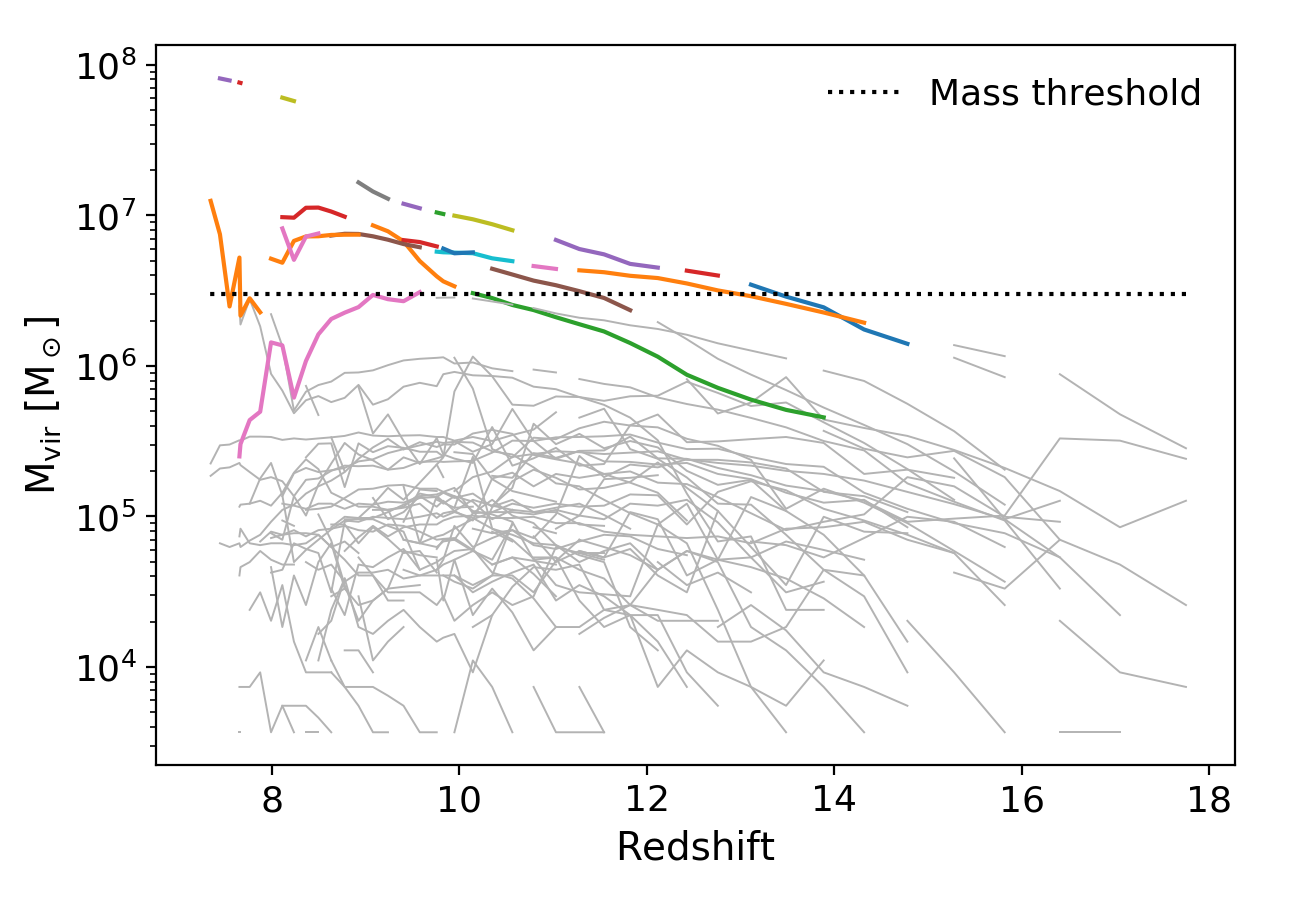

In [5]:
# Set figure frame and font properties
%matplotlib nbagg
plt.figure(figsize=(6.5,4.5))
matplotlib.rcParams.update({'font.size': 13})

# Plot the evolution of the virial mass of each branch
# Non star-forming branches will be shown as thin gray lines
for i_z in range(nb_redshifts):
    for i_b in range(len(br_halo_ID[i_z])):
        if br_is_SF[i_z][i_b]:
            plt.plot(br_z[i_z][i_b], br_m_halo[i_z][i_b])
        else:
            plt.plot(br_z[i_z][i_b], br_m_halo[i_z][i_b], color='0.7', linewidth=0.7)
plt.plot(redshifts, [m_vir_thresh]*nb_redshifts, ':k', label='Mass threshold')
        
# Set labels
plt.xlabel('Redshift', fontsize=14)
plt.ylabel('M$_\mathrm{vir}$ [M$_\odot$]', fontsize=14)
plt.legend(fontsize=13, frameon=False)
plt.yscale('log')

# Adjust the figure
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(right=0.95)
plt.subplots_adjust(left=0.12)
plt.subplots_adjust(bottom=0.15)

## 3. Run GAMMA

In [6]:
# Pre-calculate the ejecta of simple stellar populations.
# You can ignore the warning in this case.
o_for_SSPs = omega.omega(special_timesteps=2, pre_calculate_SSPs=True)

# Copy the SSPs array
SSPs_in = [o_for_SSPs.ej_SSP, o_for_SSPs.ej_SSP_coef, o_for_SSPs.dt_ssp, o_for_SSPs.t_ssp]

OMEGA run in progress..
SYGMA run in progress..
   SYGMA run completed - Run time: 0.13s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.05s
Warning -- Not enough gas to sustain the SFH. 2
   OMEGA run completed - Run time: 3.98s


In [7]:
# Prepare the list of input arrays
# Print_off = True is to avoid printing the progress of each branch.
# When running for the first time, it is best, however, to use
# Print_off = False in order to see the warning/error messages.
kwargs = {"redshifts":redshifts, "times":times, "br_halo_ID":br_halo_ID,
          "br_age":br_age, "br_z":br_z, "br_t_merge":br_t_merge, 
          "br_ID_merge":br_ID_merge, "br_m_halo":br_m_halo,
          "br_r_vir":br_r_vir, "br_is_prim":br_is_prim,
          "br_is_SF":br_is_SF, "tree_trunk_ID":tree_trunk_ID,
          "m_DM_0":m_DM_0, "pre_calculate_SSPs":True,
          "SSPs_in":SSPs_in, "print_off":True}

# Run GAMMA
g = gamma.gamma(**kwargs)

GAMMA run in progress..
   GAMMA run completed - Run time: 9.2s


## 4. Access the Results of Each Branch

Each branch is represented by an OMEGA+ model, which includes a circumgalactic medium component and an inner star-forming galactic component. The galactic component of each OMEGA+ model is represented by a one-zone OMEGA model, which is part of the <a href="https://github.com/NuGrid/NuPyCEE">NuPyCEE</a> package.

The OMEGA+ and OMEGA models of each branch are stored in the following GAMMA arrays ..
* **galaxy_inst[ redshift_index ][ branch_index ]**: OMEGA+ model
* **galaxy_inst[ redshift_index ][ branch_index ].inner**: OMEGA model

Once a model is recovered, it is possible to use its functions and quantities, in the same way as one would do if the code (OMEGA+ or OMEGA) was ran by itself.

### Plot the evolution of metallicity of each branch

<IPython.core.display.Javascript object>


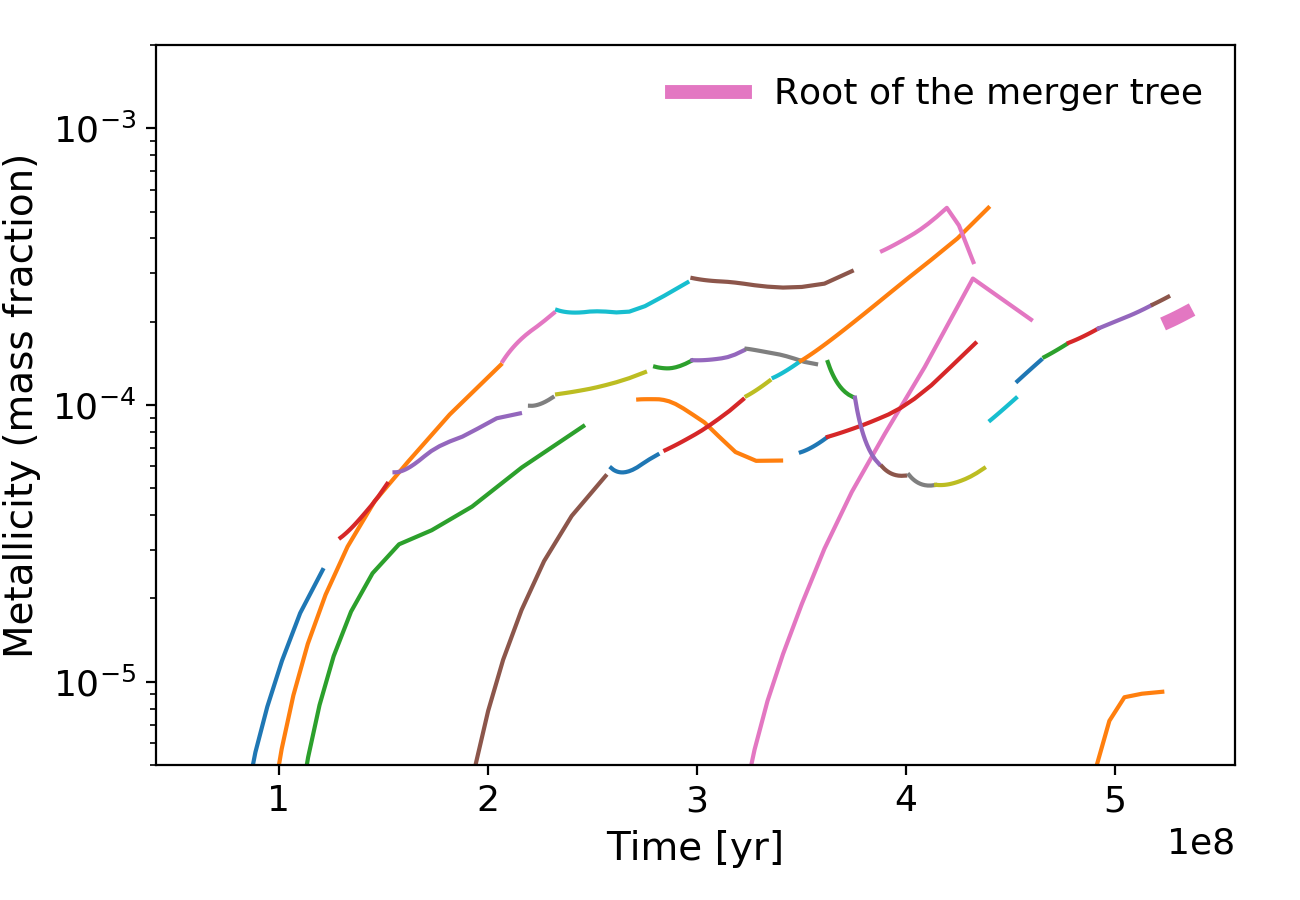

In [8]:
# Set figure frame and font properties
%matplotlib nbagg
plt.figure(figsize=(6.5,4.5))
matplotlib.rcParams.update({'font.size': 13})

# For each star-forming branch ..
for i_z in range(nb_redshifts):
    for i_b in range(len(br_halo_ID[i_z])):
        if br_is_SF[i_z][i_b]:
            
            # Copy the OMEGA (star-forming) calculation
            o = g.galaxy_inst[i_z][i_b].inner
            
            # Check if there is star formation.  Even if this is
            # technically a star-forming branch, it is possible
            # that other criteria such as gas density threshold
            # does not allow star formation.
            if sum(o.history.m_locked) > 0.0:
            
                # Copy the times and metallicities
                t_temp = np.array(o.history.age) + times[i_z]
                Z_temp = o.history.metallicity
            
                # If the galaxy eventually merges ..
                if not br_halo_ID[i_z][i_b][-1] == tree_trunk_ID:
                
                    # Copy the timestep at which the galaxy (branch) merged
                    # Please see the comment below for why the OMEGA+ calculation
                    # was not simply stopped when the galaxy merged..
                    i_t_merger = o.i_t_merger
                    
                    # Plot the evolution of metallicity for from the formation
                    # of the branch until it merges
                    plt.plot(t_temp[:i_t_merger+1], Z_temp[:i_t_merger+1])

                # Plot the complete evolution if this is the root/trunk
                else:
                    plt.plot(t_temp, Z_temp, linewidth=5, label='Root of the merger tree')
                
# Set labels
plt.yscale('log')
plt.xlabel('Time [yr]', fontsize=14)
plt.ylabel('Metallicity (mass fraction)', fontsize=14)
plt.legend(fontsize=13, frameon=False)
plt.ylim(5e-6,2e-3)

# Adjust the figure
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(right=0.95)
plt.subplots_adjust(left=0.12)
plt.subplots_adjust(bottom=0.15)

### Important note 

The quantities (e.g., metallicity) of each branch needs to be truncated at *i_t_merge*. This is because OMEGA needs to calculate the stellar ejecta that will be released in the timesteps following the merger. To do so, OMEGA needs to have more timesteps than the number required to reach the merger event.  GAMMA will then take the OMEGA stellar ejecta array, and transfer it into the new OMEGA+ calculation, representing the new system formed out of the merger.

### Plot the star formation history of each branch

<IPython.core.display.Javascript object>


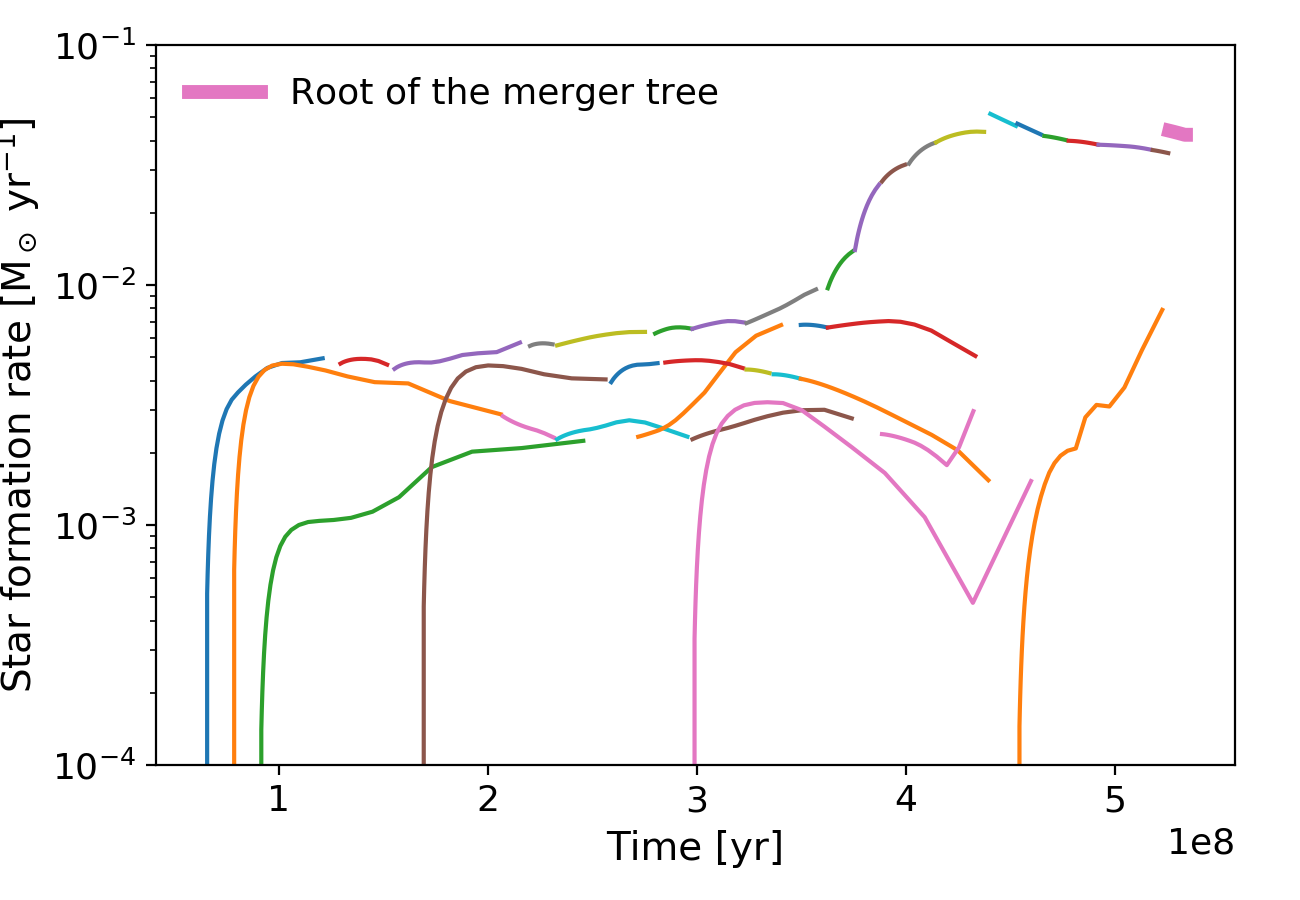

In [9]:
# Set figure frame and font properties
%matplotlib nbagg
plt.figure(figsize=(6.5,4.5))
matplotlib.rcParams.update({'font.size': 13})

# For each star-forming branch ..
for i_z in range(nb_redshifts):
    for i_b in range(len(br_halo_ID[i_z])):
        if br_is_SF[i_z][i_b]:
            
            # Copy the OMEGA (star-forming) calculation
            o = g.galaxy_inst[i_z][i_b].inner
            
            # Check if there is star formation
            if sum(o.history.m_locked) > 0.0:
            
                # Copy the times and star formation rates
                t_temp = np.array(o.history.age) + times[i_z]
                sfh_temp = o.history.sfr_abs
            
                # If the galaxy eventually merges ..
                if not br_halo_ID[i_z][i_b][-1] == tree_trunk_ID:
                
                    # Plot the evolution of metallicity for from the formation
                    # of the branch until it merges
                    i_t_merger = o.i_t_merger
                    plt.plot(t_temp[:i_t_merger+1], sfh_temp[:i_t_merger+1])

                # Plot the complete evolution if this is the root/trunk
                else:
                    plt.plot(t_temp, sfh_temp, linewidth=5, label='Root of the merger tree')
                
# Set labels
plt.yscale('log')
plt.xlabel('Time [yr]', fontsize=14)
plt.ylabel('Star formation rate [M$_\odot$ yr$^{-1}$]', fontsize=14)
plt.legend(fontsize=13, frameon=False)
plt.ylim(1e-4,1e-1)

# Adjust the figure
plt.subplots_adjust(top=0.95)
plt.subplots_adjust(right=0.95)
plt.subplots_adjust(left=0.12)
plt.subplots_adjust(bottom=0.15)